In [2]:
import sqlite3
import pandas as pd

In [3]:
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()

cursor.execute('''
CREATE TABLE buku (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    judul TEXT NOT NULL,
    penulis TEXT NOT NULL,
    tahun INTEGER NOT NULL
);
''')

cursor.execute('''
CREATE TABLE anggota (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    nama TEXT NOT NULL,
    email TEXT NOT NULL
);
''')

cursor.execute('''
CREATE TABLE peminjaman (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    id_anggota INTEGER,
    id_buku INTEGER,
    tgl_pinjam DATE,
    tgl_kembali DATE,
    FOREIGN KEY (id_anggota) REFERENCES anggota(id),
    FOREIGN KEY (id_buku) REFERENCES buku(id)
);
''')

conn.commit()


In [4]:
buku_data = [
    ('Buku A', 'Penulis A', 2020),
    ('Buku B', 'Penulis B', 2019),
    ('Buku C', 'Penulis C', 2018),
    ('Buku D', 'Penulis D', 2021),
    ('Buku E', 'Penulis E', 2022)
]

cursor.executemany('INSERT INTO buku (judul, penulis, tahun) VALUES (?, ?, ?)', buku_data)
conn.commit()

anggota_data = [
    ('Zakiyudin', 'zakiyudin@mail.com'),
    ('Raden', 'raden@mail.com'),
    ('Denz', 'denz@mail.com')
]

cursor.executemany('INSERT INTO anggota (nama, email) VALUES (?, ?)', anggota_data)
conn.commit()


In [5]:
peminjaman_data = [
    (1, 1, '2023-11-01', '2023-11-10'),
    (2, 2, '2023-11-02', '2023-11-12'),
    (3, 3, '2023-11-03', '2023-11-15'),
    (1, 4, '2023-11-05', None)
]

cursor.executemany('INSERT INTO peminjaman (id_anggota, id_buku, tgl_pinjam, tgl_kembali) VALUES (?, ?, ?, ?)', peminjaman_data)
conn.commit()


In [6]:
query = '''
SELECT a.nama, b.judul, p.tgl_pinjam, p.tgl_kembali
FROM peminjaman p
JOIN anggota a ON p.id_anggota = a.id
JOIN buku b ON p.id_buku = b.id;
'''

df_peminjaman = pd.read_sql_query(query, conn)
df_peminjaman


,nama,judul,tgl_pinjam,tgl_kembali
0,Zakiyudin,Buku A,2023-11-01,2023-11-10
1,Raden,Buku B,2023-11-02,2023-11-12
2,Denz,Buku C,2023-11-03,2023-11-15
3,Zakiyudin,Buku D,2023-11-05,None


In [7]:
query_total_buku = '''
SELECT a.nama, COUNT(p.id_buku) AS total_buku
FROM peminjaman p
JOIN anggota a ON p.id_anggota = a.id
GROUP BY a.id;
'''

df_total_buku = pd.read_sql_query(query_total_buku, conn)
df_total_buku


,nama,total_buku
0,Zakiyudin,2
1,Raden,1
2,Denz,1


In [8]:
df_peminjaman['tgl_pinjam'] = pd.to_datetime(df_peminjaman['tgl_pinjam'])
df_peminjaman['tgl_kembali'] = pd.to_datetime(df_peminjaman['tgl_kembali'], errors='coerce')

df_peminjaman['durasi'] = (df_peminjaman['tgl_kembali'] - df_peminjaman['tgl_pinjam']).dt.days
df_peminjaman


,nama,judul,tgl_pinjam,tgl_kembali,durasi
0,Zakiyudin,Buku A,2023-11-01,2023-11-10,9.0
1,Raden,Buku B,2023-11-02,2023-11-12,10.0
2,Denz,Buku C,2023-11-03,2023-11-15,12.0
3,Zakiyudin,Buku D,2023-11-05,NaT,NaN


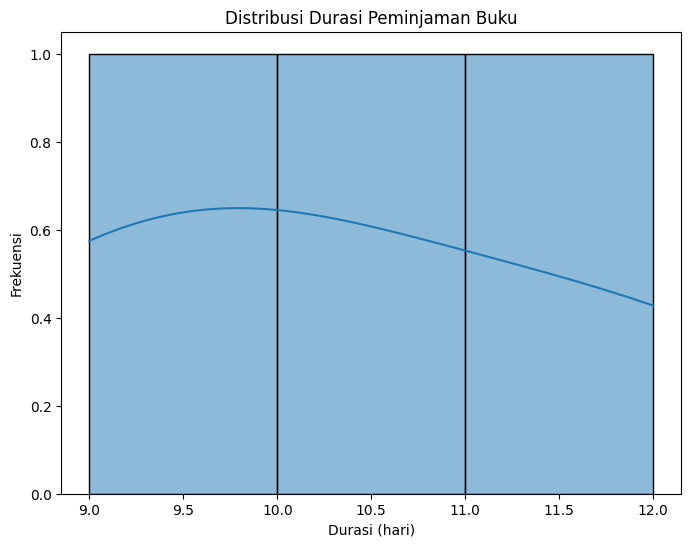

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(df_peminjaman['durasi'], kde=True)
plt.title('Distribusi Durasi Peminjaman Buku')
plt.xlabel('Durasi (hari)')
plt.ylabel('Frekuensi')
plt.show()


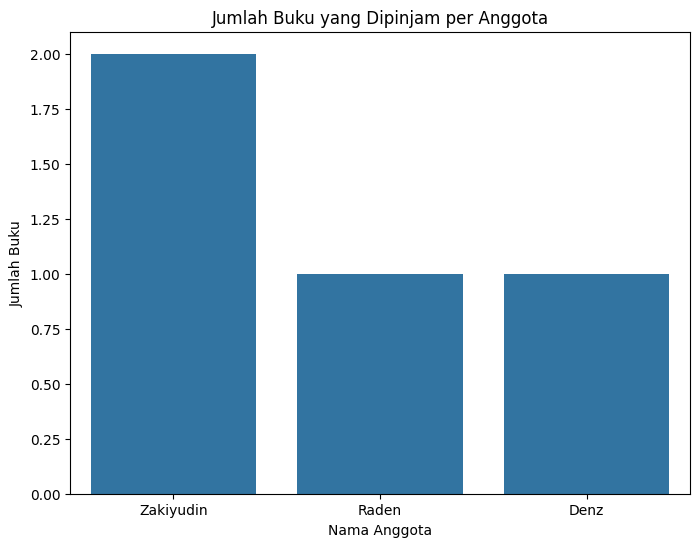

In [10]:
plt.figure(figsize=(8, 6))
sns.barplot(x='nama', y='total_buku', data=df_total_buku)
plt.title('Jumlah Buku yang Dipinjam per Anggota')
plt.xlabel('Nama Anggota')
plt.ylabel('Jumlah Buku')
plt.show()
